# 02 — Build Heterogeneous Graph from CSVs
# 
#### This notebook reads the exported CSVs from `data/raw/`,
#### builds a PyG HeteroData object, and saves it to
#### `data/processed/hetero_graph.pt`.

In [3]:
import os
from pathlib import Path

import pandas as pd
import torch
from torch_geometric.data import HeteroData

# Make sure this notebook runs from the project root:
PROJECT_ROOT = Path.cwd()
DATA_RAW = Path("/Users/domenicschmidt/Documents/master thesis/lung-cancer-gnn/data/raw")
DATA_PROCESSED = PROJECT_ROOT / "data" / "processed"
DATA_PROCESSED.mkdir(parents=True, exist_ok=True)

print("PROJECT_ROOT:", PROJECT_ROOT)
print("DATA_RAW:", DATA_RAW)
print("DATA_PROCESSED:", DATA_PROCESSED)


PROJECT_ROOT: /Users/domenicschmidt/Documents/master thesis/lung-cancer-gnn/notebooks
DATA_RAW: /Users/domenicschmidt/Documents/master thesis/lung-cancer-gnn/data/raw
DATA_PROCESSED: /Users/domenicschmidt/Documents/master thesis/lung-cancer-gnn/notebooks/data/processed


In [4]:
files = {
    "disease_gene":                    "disease_gene.csv",
    "disease_gene_fusion":             "disease_gene_fusion.csv",
    "disease_chrom_rearr":             "disease_chromosomal_rearrangement.csv",
    "disease_variant":                 "disease_variant.csv",
    "pathway_disease_association":     "pathway_disease_association.csv",
    "disease_gene_pathway":            "disease_gene_pathway.csv",
    "disease_biomarker":               "disease_biomarker.csv",
    "chemical_evidence":               "chemical_evidence.csv",
    "chemical_location":               "chemical_location.csv",
    "disease_demographics":            "disease_demographics.csv",
}

dfs = {}
for name, fname in files.items():
    path = DATA_RAW / fname
    print(f"Loading {name} from {path}")
    dfs[name] = pd.read_csv(path)

{n: df.shape for n, df in dfs.items()}


Loading disease_gene from /Users/domenicschmidt/Documents/master thesis/lung-cancer-gnn/data/raw/disease_gene.csv
Loading disease_gene_fusion from /Users/domenicschmidt/Documents/master thesis/lung-cancer-gnn/data/raw/disease_gene_fusion.csv
Loading disease_chrom_rearr from /Users/domenicschmidt/Documents/master thesis/lung-cancer-gnn/data/raw/disease_chromosomal_rearrangement.csv
Loading disease_variant from /Users/domenicschmidt/Documents/master thesis/lung-cancer-gnn/data/raw/disease_variant.csv
Loading pathway_disease_association from /Users/domenicschmidt/Documents/master thesis/lung-cancer-gnn/data/raw/pathway_disease_association.csv
Loading disease_gene_pathway from /Users/domenicschmidt/Documents/master thesis/lung-cancer-gnn/data/raw/disease_gene_pathway.csv
Loading disease_biomarker from /Users/domenicschmidt/Documents/master thesis/lung-cancer-gnn/data/raw/disease_biomarker.csv
Loading chemical_evidence from /Users/domenicschmidt/Documents/master thesis/lung-cancer-gnn/data/

/var/folders/lj/bdrxx0g5275bd033dh_9k0h00000gn/T/ipykernel_49342/1431960707.py:18: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  dfs[name] = pd.read_csv(path)


{'disease_gene': (82461, 5),
 'disease_gene_fusion': (4289, 3),
 'disease_chrom_rearr': (2309, 4),
 'disease_variant': (500000, 15),
 'pathway_disease_association': (168, 7),
 'disease_gene_pathway': (50651, 7),
 'disease_biomarker': (24, 4),
 'chemical_evidence': (198, 4),
 'chemical_location': (373, 8),
 'disease_demographics': (204, 5)}

# Build node ID maps (external ID -> internal index)


In [5]:
node_maps = {
    "disease": {},
    "gene": {},
    "variant": {},
    "gene_fusion": {},
    "chrom_rearr": {},
    "pathway": {},
    "biomarker": {},
    "chemical": {},
    "evidence": {},
    "city": {},
    "demographic_group": {},
}

def add_ids(node_type: str, ids):
    """Adds IDs to node_maps[node_type] if not present yet."""
    mapping = node_maps[node_type]
    for ext_id in ids:
        if pd.isna(ext_id):
            continue
        if ext_id not in mapping:
            mapping[ext_id] = len(mapping)

# --- Diseases ---
for name, df in dfs.items():
    if "DiseaseCui" in df.columns:
        add_ids("disease", df["DiseaseCui"].unique())

# --- Genes ---
if "disease_gene" in dfs:
    add_ids("gene", dfs["disease_gene"]["GeneId"].unique())
if "disease_gene_pathway" in dfs:
    add_ids("gene", dfs["disease_gene_pathway"]["GeneId"].unique())
if "disease_variant" in dfs:
    add_ids("gene", dfs["disease_variant"]["GeneId"].unique())

# --- Variants ---
add_ids("variant", dfs["disease_variant"]["VariantId"].unique())

# --- Gene fusions ---
add_ids("gene_fusion", dfs["disease_gene_fusion"]["GeneFusion"].unique())

# --- Chromosomal rearrangements ---
add_ids("chrom_rearr", dfs["disease_chrom_rearr"]["ChromosomalRearrengementName"].unique())

# --- Pathways ---
add_ids("pathway", dfs["disease_gene_pathway"]["PathwayId"].unique())
add_ids("pathway", dfs["pathway_disease_association"]["PathwayId"].unique())

# --- Biomarkers ---
add_ids("biomarker", dfs["disease_biomarker"]["BiomarkerId"].unique())

# --- Chemicals ---
add_ids("chemical", dfs["chemical_evidence"]["ChemicalId"].unique())
add_ids("chemical", dfs["chemical_location"]["ChemicalId"].unique())

# --- Evidence ---
add_ids("evidence", dfs["chemical_evidence"]["EvidenceId"].unique())

# --- Cities ---
add_ids("city", dfs["chemical_location"]["CityId"].unique())

# --- Demographic groups ---
add_ids("demographic_group", dfs["disease_demographics"]["DemographicGroup"].unique())

# Show node counts
pd.DataFrame(
    {nt: len(m) for nt, m in node_maps.items()}.items(),
    columns=["node_type", "num_nodes"]
)


,node_type,num_nodes
0,disease,58
1,gene,14779
2,variant,285747
3,gene_fusion,4266
4,chrom_rearr,1993
5,pathway,1488
6,biomarker,24
7,chemical,160
8,evidence,144
9,city,368


# Create HeteroData and assign node counts / simple features


In [6]:
data = HeteroData()

for node_type, mapping in node_maps.items():
    num_nodes = len(mapping)
    data[node_type].num_nodes = num_nodes
    # simple dummy feature: all ones, 1-dimensional
    data[node_type].x = torch.ones((num_nodes, 1), dtype=torch.float)

data


HeteroData(
  disease={
    num_nodes=58,
    x=[58, 1],
  },
  gene={
    num_nodes=14779,
    x=[14779, 1],
  },
  variant={
    num_nodes=285747,
    x=[285747, 1],
  },
  gene_fusion={
    num_nodes=4266,
    x=[4266, 1],
  },
  chrom_rearr={
    num_nodes=1993,
    x=[1993, 1],
  },
  pathway={
    num_nodes=1488,
    x=[1488, 1],
  },
  biomarker={
    num_nodes=24,
    x=[24, 1],
  },
  chemical={
    num_nodes=160,
    x=[160, 1],
  },
  evidence={
    num_nodes=144,
    x=[144, 1],
  },
  city={
    num_nodes=368,
    x=[368, 1],
  },
  demographic_group={
    num_nodes=204,
    x=[204, 1],
  }
)

# Helper to build edges from a DataFrame


In [7]:
def build_edges(df, src_col, dst_col, src_type, dst_type):
    """Return edge_index (2 x num_edges) for given df and node types."""
    src_map = node_maps[src_type]
    dst_map = node_maps[dst_type]

    src_idx = []
    dst_idx = []

    for _, row in df[[src_col, dst_col]].dropna().iterrows():
        s_id = row[src_col]
        d_id = row[dst_col]
        if s_id not in src_map or d_id not in dst_map:
            # theoretisch sollte alles gemappt sein; falls nicht, skip
            continue
        src_idx.append(src_map[s_id])
        dst_idx.append(dst_map[d_id])

    if len(src_idx) == 0:
        print(f"[WARN] No edges built for {src_type}->{dst_type} from {src_col},{dst_col}")
        return torch.empty((2, 0), dtype=torch.long)

    edge_index = torch.tensor([src_idx, dst_idx], dtype=torch.long)
    return edge_index



# Biological relations


In [8]:
# disease --assoc_gene--> gene
data["disease", "assoc_gene", "gene"].edge_index = build_edges(
    dfs["disease_gene"],
    src_col="DiseaseCui",
    dst_col="GeneId",
    src_type="disease",
    dst_type="gene",
)

# disease --assoc_gene_fusion--> gene_fusion
data["disease", "assoc_gene_fusion", "gene_fusion"].edge_index = build_edges(
    dfs["disease_gene_fusion"],
    src_col="DiseaseCui",
    dst_col="GeneFusion",
    src_type="disease",
    dst_type="gene_fusion",
)

# disease --assoc_chrom_rearr--> chrom_rearr
data["disease", "assoc_chrom_rearr", "chrom_rearr"].edge_index = build_edges(
    dfs["disease_chrom_rearr"],
    src_col="DiseaseCui",
    dst_col="ChromosomalRearrengementName",
    src_type="disease",
    dst_type="chrom_rearr",
)

# disease --assoc_variant--> variant
data["disease", "assoc_variant", "variant"].edge_index = build_edges(
    dfs["disease_variant"],
    src_col="DiseaseCui",
    dst_col="VariantId",
    src_type="disease",
    dst_type="variant",
)

# disease --assoc_pathway--> pathway (from pathway_disease_association)
data["disease", "assoc_pathway", "pathway"].edge_index = build_edges(
    dfs["pathway_disease_association"],
    src_col="DiseaseCui",
    dst_col="PathwayId",
    src_type="disease",
    dst_type="pathway",
)

# gene --participates_in--> pathway (from disease_gene_pathway)
data["gene", "participates_in", "pathway"].edge_index = build_edges(
    dfs["disease_gene_pathway"],
    src_col="GeneId",
    dst_col="PathwayId",
    src_type="gene",
    dst_type="pathway",
)

# disease --assoc_biomarker--> biomarker
data["disease", "assoc_biomarker", "biomarker"].edge_index = build_edges(
    dfs["disease_biomarker"],
    src_col="DiseaseCui",
    dst_col="BiomarkerId",
    src_type="disease",
    dst_type="biomarker",
)


# Environmental & demographic relations

In [9]:
# chemical --has_evidence--> evidence
data["chemical", "has_evidence", "evidence"].edge_index = build_edges(
    dfs["chemical_evidence"],
    src_col="ChemicalId",
    dst_col="EvidenceId",
    src_type="chemical",
    dst_type="evidence",
)

# chemical --measured_in--> city
data["chemical", "measured_in", "city"].edge_index = build_edges(
    dfs["chemical_location"],
    src_col="ChemicalId",
    dst_col="CityId",
    src_type="chemical",
    dst_type="city",
)

# disease --has_demographic_stats--> demographic_group
data["disease", "has_demographic_stats", "demographic_group"].edge_index = build_edges(
    dfs["disease_demographics"],
    src_col="DiseaseCui",
    dst_col="DemographicGroup",
    src_type="disease",
    dst_type="demographic_group",
)


# Sanity check: match counts with expectation


In [10]:
print("Node types & num_nodes:")
for nt in data.node_types:
    print(f"  {nt:17s} → {data[nt].num_nodes}")

print("\nEdge types & num_edges:")
for et in data.edge_types:
    edge_index = data[et].edge_index
    print(f"  {et} → {edge_index.shape[1]} edges")


Node types & num_nodes:
  disease           → 58
  gene              → 14779
  variant           → 285747
  gene_fusion       → 4266
  chrom_rearr       → 1993
  pathway           → 1488
  biomarker         → 24
  chemical          → 160
  evidence          → 144
  city              → 368
  demographic_group → 204

Edge types & num_edges:
  ('disease', 'assoc_gene', 'gene') → 82461 edges
  ('disease', 'assoc_gene_fusion', 'gene_fusion') → 4289 edges
  ('disease', 'assoc_chrom_rearr', 'chrom_rearr') → 2309 edges
  ('disease', 'assoc_variant', 'variant') → 500000 edges
  ('disease', 'assoc_pathway', 'pathway') → 168 edges
  ('gene', 'participates_in', 'pathway') → 50651 edges
  ('disease', 'assoc_biomarker', 'biomarker') → 24 edges
  ('chemical', 'has_evidence', 'evidence') → 198 edges
  ('chemical', 'measured_in', 'city') → 373 edges
  ('disease', 'has_demographic_stats', 'demographic_group') → 204 edges


# Save hetero_graph.pt


In [11]:
obj = {
    "data": data,
    "node_maps": node_maps,
}

out_path = DATA_PROCESSED / "hetero_graph.pt"
torch.save(obj, out_path)
print("Saved hetero graph to:", out_path)


Saved hetero graph to: /Users/domenicschmidt/Documents/master thesis/lung-cancer-gnn/notebooks/data/processed/hetero_graph.pt


# Reload & quick summary


In [12]:
reloaded = torch.load(out_path, weights_only=False)
data2 = reloaded["data"]
node_maps2 = reloaded["node_maps"]

print(data2)


HeteroData(
  disease={
    num_nodes=58,
    x=[58, 1],
  },
  gene={
    num_nodes=14779,
    x=[14779, 1],
  },
  variant={
    num_nodes=285747,
    x=[285747, 1],
  },
  gene_fusion={
    num_nodes=4266,
    x=[4266, 1],
  },
  chrom_rearr={
    num_nodes=1993,
    x=[1993, 1],
  },
  pathway={
    num_nodes=1488,
    x=[1488, 1],
  },
  biomarker={
    num_nodes=24,
    x=[24, 1],
  },
  chemical={
    num_nodes=160,
    x=[160, 1],
  },
  evidence={
    num_nodes=144,
    x=[144, 1],
  },
  city={
    num_nodes=368,
    x=[368, 1],
  },
  demographic_group={
    num_nodes=204,
    x=[204, 1],
  },
  (disease, assoc_gene, gene)={ edge_index=[2, 82461] },
  (disease, assoc_gene_fusion, gene_fusion)={ edge_index=[2, 4289] },
  (disease, assoc_chrom_rearr, chrom_rearr)={ edge_index=[2, 2309] },
  (disease, assoc_variant, variant)={ edge_index=[2, 500000] },
  (disease, assoc_pathway, pathway)={ edge_index=[2, 168] },
  (gene, participates_in, pathway)={ edge_index=[2, 50651] },
  (d

# Schema overview (type-level graph)


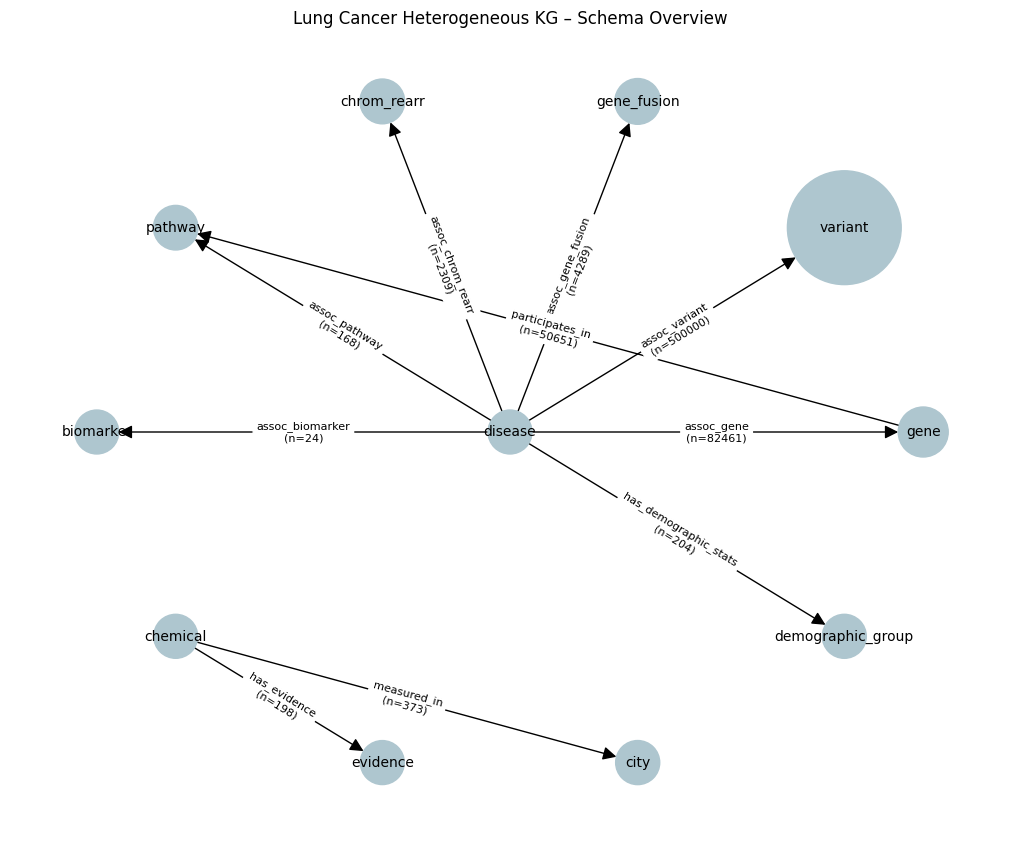

In [13]:
import networkx as nx
import matplotlib.pyplot as plt
import math

G = nx.DiGraph()

# Node-Typen + Größe aus data
for nt in data.node_types:
    G.add_node(nt, size=data[nt].num_nodes)

# Edge-Typen + Kantenanzahl
for (src, rel, dst) in data.edge_types:
    num_edges = data[(src, rel, dst)].edge_index.shape[1]
    G.add_edge(src, dst, rel=rel, count=num_edges)

# Layout: disease in die Mitte, Rest im Kreis
center = "disease"
pos = {center: (0.0, 0.0)}
others = [n for n in G.nodes if n != center]
radius = 3.0

for i, n in enumerate(others):
    angle = 2 * math.pi * i / len(others)
    pos[n] = (radius * math.cos(angle), radius * math.sin(angle))

plt.figure(figsize=(10, 8))

# Node-Größen skalieren
sizes = [1000 + 0.02 * G.nodes[n]["size"] for n in G.nodes]

nx.draw(
    G,
    pos,
    with_labels=True,
    node_size=sizes,
    node_color="#aec6cf",
    arrows=True,
    arrowstyle="-|>",
    arrowsize=20,
    font_size=10,
)

# Kantenlabels: rel + n
edge_labels = {}
for u, v, d in G.edges(data=True):
    edge_labels[(u, v)] = f'{d["rel"]}\n(n={d["count"]})'

nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)

plt.title("Lung Cancer Heterogeneous KG – Schema Overview")
plt.axis("off")
plt.show()
